# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System

"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."

https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx



In [1]:
# Imports

import calendar
from code_id_translator import *
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact, fixed
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from neiss_backend_v8 import *
import numpy as np
import os
import pandas as pd
import pickle
import re
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn import metrics
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import sys
import xlrd



In [2]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

## Read the pickled neissYYYY.xlsx file

xlsx_to_pckl.ipynb is used to create the pickled file

In [3]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    dfNeiss = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception('ERROR:  {} does not exist'.format(pckl_fname))


Reading /Users/mcorbett/Boston University/MET_CS677_DataScienceWithPython/Project/data/NEISS/neiss_data.pckl  ... done!


In [4]:
dfNeiss.shape

(7352927, 19)

In [5]:
dfNeiss.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,100001,1999-12-24,41,2,1.0,0,31,71,NaN,1,0,0,3299,0,41 YR FEMALE FELL WHILE WALKING. DX: SEVERE MU...,/RIGHT BUTTOCKS & BACK.,S,71,68.1086
1,100002,1999-12-27,80,1,2.0,0,31,57,NaN,1,0,0,611,0,80 YR MALE FELL IN BATHROOM/HE HIT RIGHT RIBS ...,DX: FRACTURED RIGHT RIBS-UPPER TRUNK,S,71,68.1086
2,100003,1999-12-27,4,1,1.0,0,75,53,NaN,1,0,0,1328,0,4 YR MALE HAD METAL LARGE WAGON WHEEL FALL & H...,DX: CONTUSIN ON HEAD/NO LOC.,S,71,68.1086
3,100005,1999-12-28,18,1,0.0,NaN,94,53,NaN,1,0,0,1205,0,CONTUSION EAR - STRUCK IN RIGHT EAR WITH BASKE...,NaN,S,7,68.1086
4,100009,1999-12-28,19,2,0.0,NaN,92,64,NaN,1,0,0,5031,0,SPRAIN THUMB - INJURED THUMB WHEN SNOWBOARDING,NaN,S,7,68.1086


### Update Neiss with column code dictionary from Excel file

In [6]:
column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)

- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [7]:
neiss = Neiss(dfNeiss)

In [8]:
dfNeiss.shape

(7352927, 19)

### Time based graphs

#### Injuries Per Year

 Note:  The first graph requires the entire dataset

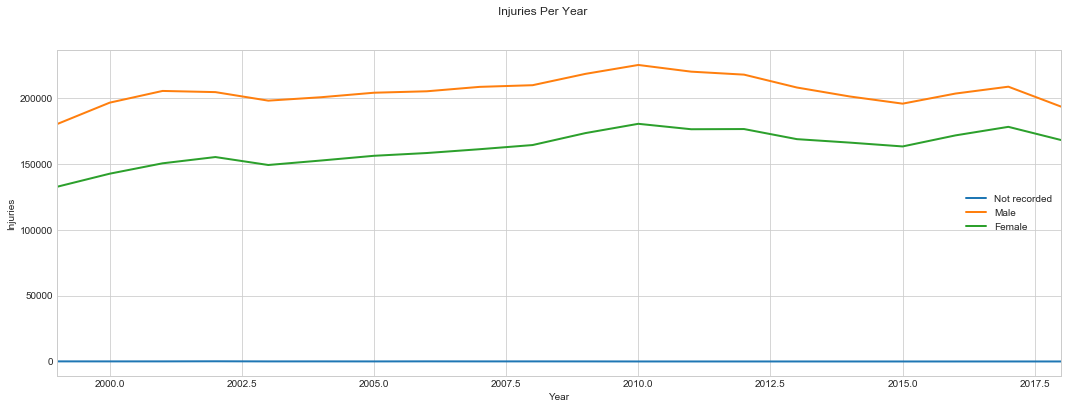

In [9]:
#df = neiss.getDataFrame()
date_name, stat_name = 'Treatment_Date', 'Sex'

showInjuriesPerYear(dfNeiss, date_name, stat_name, 'Injuries Per Year')

#### Injuries Per 52 Weeks of the Year

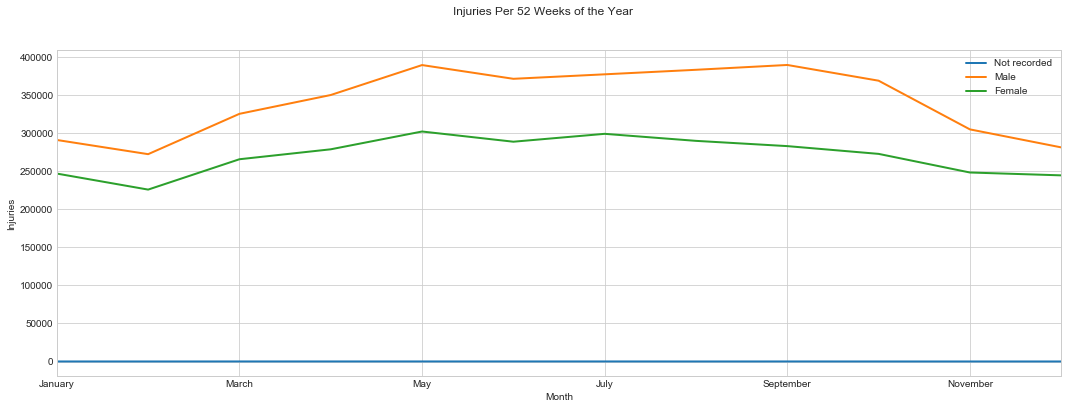

In [10]:
showInjuriesPerMonthOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per 52 Weeks of the Year')

#### Injuries Per Month of the Year

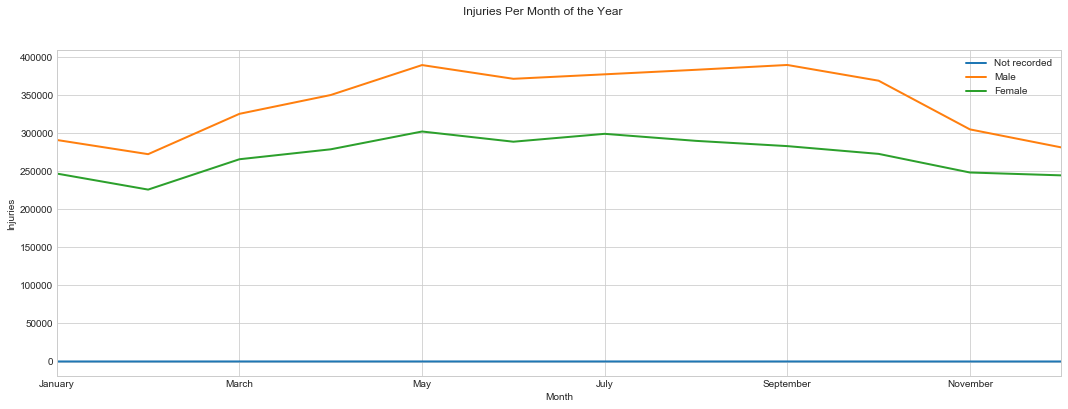

In [11]:
showInjuriesPerMonthOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per Month of the Year')

#### Injuries Per Week of the Year

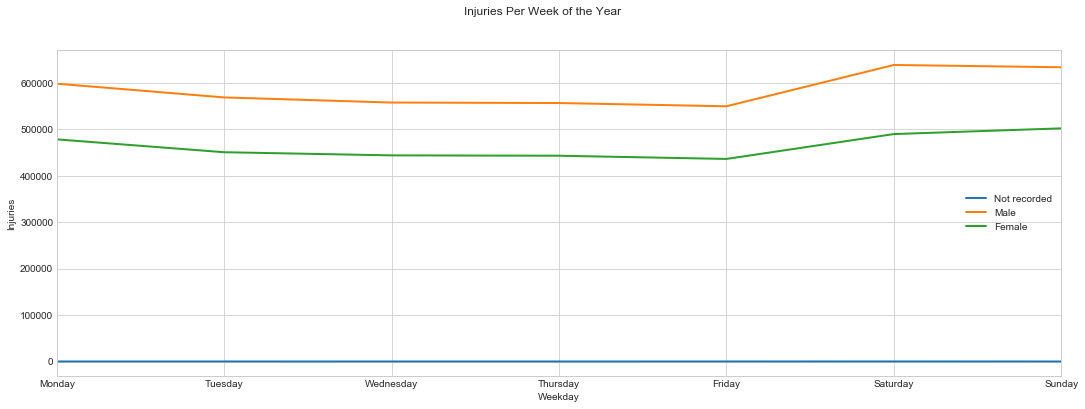

In [12]:
showInjuriesPerWeekOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per Week of the Year')

### PearsonChiSquared

dfCategorical.head:
        Sex  Race  Body_Part  Diagnosis  Disposition  Location  \
49028     2     3         92         63            1         0   
271112    1     1         33         57            1         9   
93746     2     1         85         68            5         5   
390591    2     2         85         68            1         1   
307974    1     0         75         62            1         4   

        Fire_Involvement  Product_1  Product_2  PSU Stratum  
49028                  0       1819          0   35       V  
271112                 0       3246          0   31       C  
93746                  0       1647          0   91       V  
390591                 0        973          0   90       C  
307974                 0       1333          0   37       C  
                                                                  translator
Function Category                                                           
codeToId Body_Part         [{0: 1, 30: 2, 31: 3, 32: 4, 3

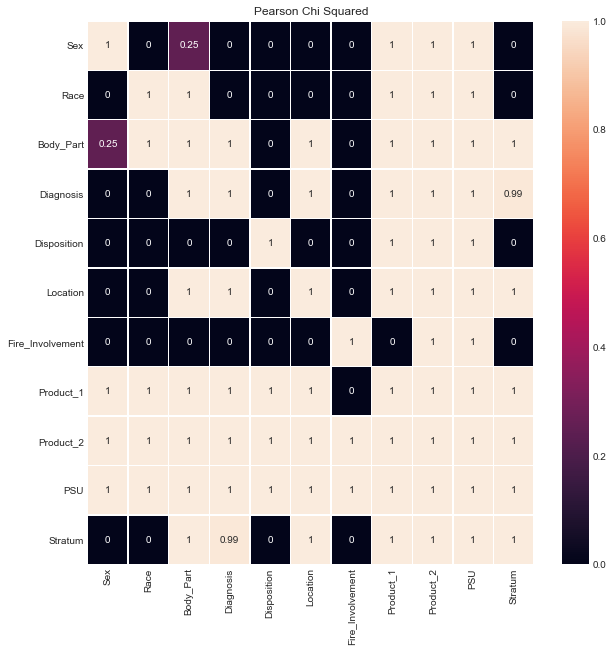

In [13]:
# build the correlation matrix (contingency table)
dfCategorical = dfNeiss.copy()
categorical = ['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Disposition', 'Location',
               'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum' ]
dfCategorical = dfCategorical.xs(categorical, axis=1)
dfCategorical.dropna(inplace=True)
dfCategorical['Race'] = [int(x) for x in dfCategorical['Race']]
dfCategorical = dfCategorical.sample(3000)
print('dfCategorical.head:\n{}'.format(dfCategorical.head()))

codeIdTranslator = CodeIdTranslatorDataFrame(dfCategorical, categorical)
print(codeIdTranslator.state)
codeIdTranslator.transformColumns()

pcs1 = PearsonChiSquared(dfCategorical)
dfCategoricalCorrMatrix = pcs1.getCorrMatrixDataframe(categorical)


fig, ax = plt.subplots(figsize=(10, 10))

#sns.heatmap(dfCorrMatrix, annot=True, mask=mask, fmt="d", linewidths=0.4, ax=ax)
g = sns.heatmap(dfCategoricalCorrMatrix, annot=True, linewidths=0.4, ax=ax)
g.set_title('Pearson Chi Squared')
# Fix the top and bottom margins of the heatmap
bottom_y, top_y = plt.ylim() 
bottom_y += 0.5 
top_y -= 0.5 
plt.ylim(bottom_y, top_y)

plt.show() 

### Python Corr

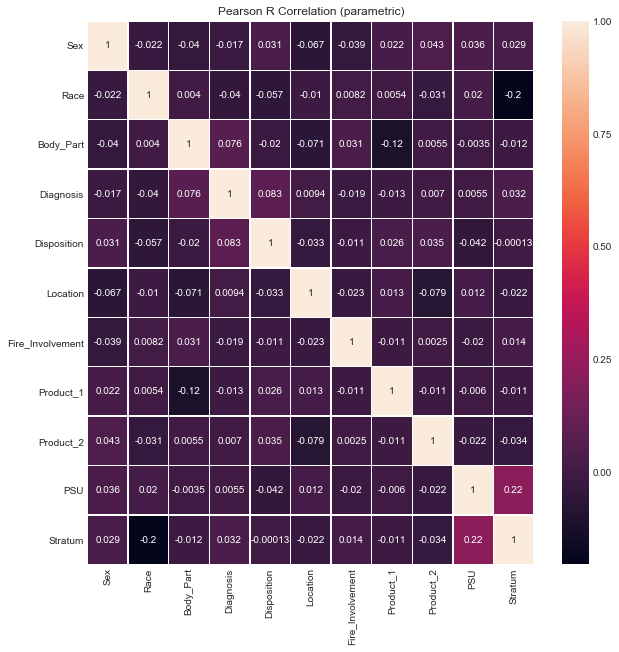

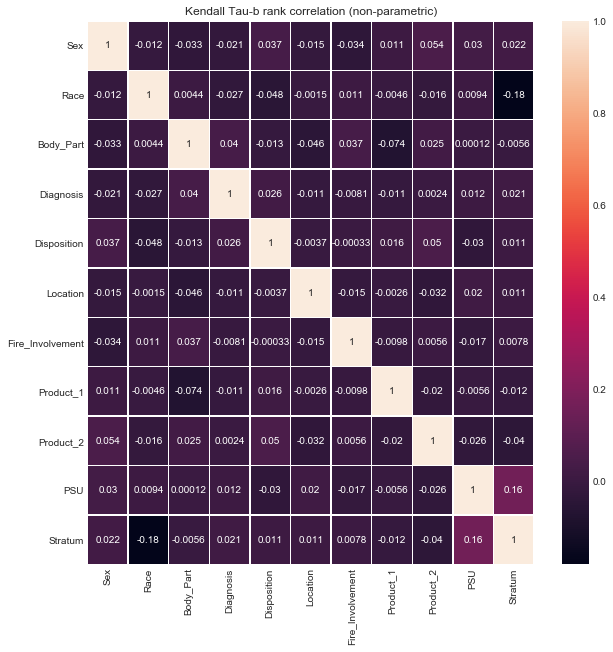

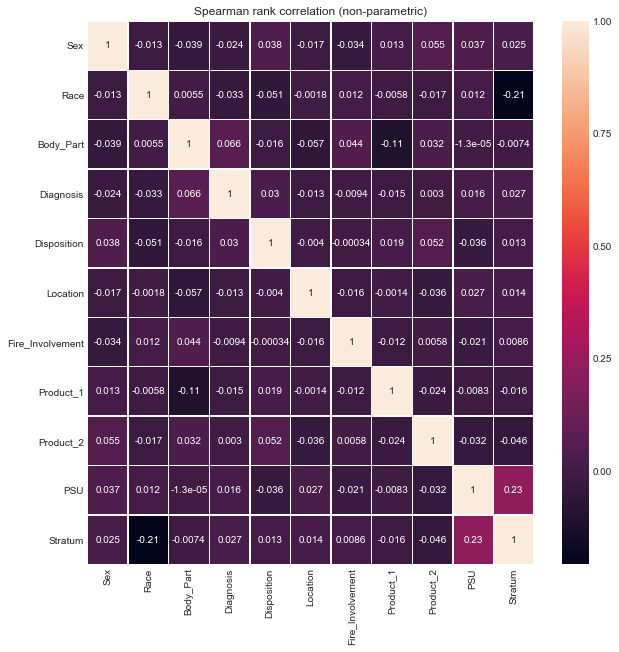

In [14]:

methods = {
    'pearson' : 'Pearson R Correlation (parametric)',  # not good for categorical data
        # For pearson:
        # both variables should be normally distributed
        # There should be no significant outliers
        # Each variable should be continuous
        # The two variables have a linear relationship
        # The observations are paired observations.
        # Should support homoscedascity.  Homoscedascity simply refers to ‘equal variances’.
    'kendall' : 'Kendall Tau-b rank correlation (non-parametric)',
        # The variables are measured on an ordinal or continuous scale.
        # Desirable if your data appears to follow a monotonic relationship.
    'spearman' : 'Spearman rank correlation (non-parametric)'
        # Does not assume that both datasets are normally distributed
    }


for key in methods.keys():
    dfCategoricalPythonCorr = dfCategorical.corr(method = key)

    fig, ax = plt.subplots(figsize=(10, 10))

    g = sns.heatmap(dfCategoricalPythonCorr, annot=True, linewidths=0.4, ax=ax)
    g.set_title(methods[key])

    # Fix the top and bottom margins of the heatmap
    bottom_y, top_y = plt.ylim() 
    bottom_y += 0.5 
    top_y -= 0.5 
    plt.ylim(bottom_y, top_y)

    plt.show() 


In [15]:
#sns.pairplot(df)

In [16]:
def getHighCorrelations(df, dfCategoricalCorrMatrix, minValue):
    high_correlations = []
    for yIndex, y in enumerate(dfCategoricalCorrMatrix.index):
        for xIndex, x in enumerate(dfCategoricalCorrMatrix.columns):
            #if xIndex >= yIndex:
            #    break

            if (x != y) and (dfCategoricalCorrMatrix[y][x] > minValue):
                Y = y
                X = x
                if len(df[X].unique()) > len(df[Y].unique()):
                    # Keep the smallest item on the X axis
                    Y, X = X, Y
                    
                if (Y, X) not in high_correlations:
                    high_correlations.insert(-1, (Y, X))
    high_correlations.sort()
    return high_correlations

high_correlations = getHighCorrelations(dfCategorical, dfCategoricalCorrMatrix, 0.95)
for n in high_correlations:
    print(n)

('Body_Part', 'Location')
('Body_Part', 'Race')
('Body_Part', 'Stratum')
('Diagnosis', 'Body_Part')
('Diagnosis', 'Location')
('Diagnosis', 'Stratum')
('Location', 'Stratum')
('PSU', 'Body_Part')
('PSU', 'Diagnosis')
('PSU', 'Disposition')
('PSU', 'Fire_Involvement')
('PSU', 'Location')
('PSU', 'Race')
('PSU', 'Sex')
('PSU', 'Stratum')
('Product_1', 'Body_Part')
('Product_1', 'Diagnosis')
('Product_1', 'Disposition')
('Product_1', 'Location')
('Product_1', 'PSU')
('Product_1', 'Product_2')
('Product_1', 'Race')
('Product_1', 'Sex')
('Product_1', 'Stratum')
('Product_2', 'Body_Part')
('Product_2', 'Diagnosis')
('Product_2', 'Disposition')
('Product_2', 'Fire_Involvement')
('Product_2', 'Location')
('Product_2', 'PSU')
('Product_2', 'Race')
('Product_2', 'Sex')
('Product_2', 'Stratum')


In [18]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

#print(high_correlations.values)
select = high_correlations[0]
#print(select)
lCorrelations = ['{}, {}'.format(y, x) for y, x in high_correlations]
correlationDropDownSel = widgets.Dropdown(
    options=lCorrelations,
    value=lCorrelations[0],
    description='correlations',
    disabled=False,
)

typeDropDownSel = widgets.Dropdown(
    options=['swarm', 'scatter'],
    value='swarm',
    description='plot_type',
    disabled=False,
)

wHBox = widgets.HBox([correlationDropDownSel, typeDropDownSel])
wVBox = widgets.VBox([wHBox, button, output])

display(wVBox)

def on_button_clicked(b):
    with output:
        sel = correlationDropDownSel.value
        (xSel, ySel) = [x.strip() for x in sel.split(',')]
        print('-{}-, -{}-'.format(xSel, ySel))
        
        correlations(codeIdTranslator, xSel, ySel, typeDropDownSel.value)

        #sns.pairplot(dfSel, hue=xSel)
button.on_click(on_button_clicked)


## SKLearn - Gaussian Naive Bayes (GaussianNB)


Can perform online updates to model parameters via partial_fit method. 

For details on algorithm used to update feature means and variance online, 

see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:


http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf


In [19]:
    currentState = codeIdTranslator.getState()
    codeIdTranslator.setState('id')
    dfCorrelationsId = codeIdTranslator.getDataFrame().copy()
    codeIdTranslator.setState('code')
    dfCorrelationsCode = codeIdTranslator.getDataFrame().copy()
    codeIdTranslator.setState(currentState)


In [20]:
df1 = dfCorrelationsCode.copy()

le = {}

for col in df1.columns:
    le[col] = preprocessing.LabelEncoder()
    le[col].fit(df1[col].unique())
    print('{0:12s} => {1}'.format(col, le[col].classes_))
    df1[col] = le[col].transform(df1[col])
    
df1

Sex          => [0 1 2]
Race         => [0 1 2 3 4 5]
Body_Part    => [ 0 30 31 32 33 34 35 36 37 38 75 76 77 79 80 81 82 83 84 85 87 88 89 92
 93 94]
Diagnosis    => [41 42 46 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69 70 71 72 73 74]
Disposition  => [1 2 4 5 6 8 9]
Location     => [0 1 2 4 5 6 8 9]
Fire_Involvement => [0 1 2 3 4]
Product_1    => [ 110  115  127  134  137  140  214  215  259  263  264  266  276  277
  281  342  367  371  374  379  380  381  393  399  413  419  420  428
  431  438  452  453  460  461  464  466  474  478  480  519  546  550
  552  556  557  566  569  572  604  609  611  612  613  618  620  627
  638  648  649  652  653  654  657  661  662  670  671  672  676  679
  685  687  689  694  698  699  701  707  709  809  814  827  828  830
  832  834  835  836  841  845  852  857  867  869  870  878  880  881
  882  884  885  886  888  893  899  909  910  913  921  934  936  938
  945  949  954  956  957  960  962  973  983 1023 1062 11

,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,PSU,Stratum
49028,2,3,23,18,0,0,0,256,0,33,4
271112,1,1,4,12,0,7,0,303,0,29,0
93746,2,1,19,23,3,4,0,231,0,87,4
390591,2,2,19,23,0,1,0,119,0,86,0
307974,1,0,10,17,0,3,0,179,0,35,0
...,...,...,...,...,...,...,...,...,...,...,...
172229,1,1,10,14,0,0,0,179,0,18,0
57506,1,0,2,26,0,0,0,230,0,19,4
121782,1,2,19,26,3,0,0,115,25,67,1
191149,1,0,13,26,0,7,0,143,0,19,4


In [21]:

outputFeature = 'Diagnosis'

categories = categorical.copy()
categories.remove(outputFeature)

df2 = dfCorrelationsId
for category in categories:
    print("----------------------------")
    print(category)
    print

    inputFeature = [category]

    # Train classifier
    gnb = GaussianNB()
    gnb.fit(
        df2[inputFeature].values,
        df2[outputFeature]
    )

    y_pred = gnb.predict(dfCorrelationsId[inputFeature])
    print(y_pred)

    # Print results
    print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
          .format(
              df2.shape[0],
              (df2[outputFeature] != y_pred).sum(),
              100*(1-(df2[outputFeature] != y_pred).sum()/df2.shape[0])
    ))

    pd.DataFrame(
        {'predicted': le[outputFeature].inverse_transform(y_pred),
         'actual':    df2[outputFeature]})

    #print(metrics.confusion_matrix(y_pred, df2[outputFeature]))


----------------------------
Sex
[26  3 26 ...  3  3  3]
Number of mislabeled points out of a total 3000 points : 2998, performance 00.07%
----------------------------
Race
[20 26 26 ...  3 23  3]
Number of mislabeled points out of a total 3000 points : 2963, performance 01.23%
----------------------------
Body_Part
[ 6 20 24 ... 24 17 16]
Number of mislabeled points out of a total 3000 points : 2625, performance 12.50%
----------------------------
Disposition
[20 20 27 ... 27 20 20]
Number of mislabeled points out of a total 3000 points : 2498, performance 16.73%
----------------------------
Location
[23 20 13 ... 23 20 23]
Number of mislabeled points out of a total 3000 points : 2813, performance 06.23%
----------------------------
Fire_Involvement
[15 15 15 ... 15 15 15]
Number of mislabeled points out of a total 3000 points : 2433, performance 18.90%
----------------------------
Product_1
[ 9  9  9 ... 15 15  9]
Number of mislabeled points out of a total 3000 points : 2392, perform

In [22]:
# Drop categories with low scores
categories1 = categories.copy()
categories1.remove('Sex')
categories1.remove('Disposition')
categories1.remove('Location')
categories1.remove('Product_2')
categories1.remove('Stratum')


In [23]:
df2A = df2.copy()

In [24]:
df2A.drop(['Sex', 'Disposition', 'Location', 'Product_2', 'Stratum'], axis=1, inplace=True)

In [26]:
print(df2A.shape)
#print(df2A.headcategories1
print('InputFeatures=', categories1)

for category in categories1:
    print("----------------------------")
    print(category)
    print()

    inputFeature = [category]

    # Train classifier
    gnb = GaussianNB()
    gnb.fit(
        df2A[inputFeature].values,
        df2A[outputFeature]
    )

    y_pred = gnb.predict(dfCorrelationsId[inputFeature])
    print(y_pred)

    # Print results
    print(df2A.shape)
    print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
          .format(
              df2A.shape[0],
              (df2A[outputFeature] != y_pred).sum(),
              100*(1-(df2A[outputFeature] != y_pred).sum()/df2A.shape[0])
    ))
    pd.DataFrame(
        {'predicted': le[outputFeature].inverse_transform(y_pred),
         'actual':    df2A[outputFeature]})

    # df2A[outputFeature] has 29 unique values.  That is why there are 29 columns
    print(metrics.confusion_matrix(y_pred, df2A[outputFeature]))


(3000, 6)
InputFeatures= ['Race', 'Body_Part', 'Fire_Involvement', 'Product_1', 'PSU']
----------------------------
Race

[20 26 26 ...  3 23  3]
(3000, 6)
Number of mislabeled points out of a total 3000 points : 2963, performance 01.23%
30
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   1   1   7   0   1   6   3  76   0   6  11  57   3  84   4   1  29
    3  75   3   1   0   7   1   0  53   5   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0

## Linear regression (using chi2)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

- f_classif:  ANOVA F-value between label/feature for classification tasks.

- mutual_info_classif: Mutual information for a discrete target.

- chi2:  Chi-squared stats of non-negative features for classification tasks.

- f_regression:  F-value between label/feature for regression tasks.

- mutual_info_regression:  Mutual information for a continuous target.
    
- SelectPercentile:  Select features based on percentile of the highest scores.

- SelectFpr:  Select features based on a false positive rate test.

- SelectFdr:  Select features based on an estimated false discovery rate.

- SelectFwe:  Select features based on family-wise error rate.

- GenericUnivariateSelect:  Univariate feature selector with configurable mode.


In [27]:
from sklearn import datasets
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, f_regression, mutual_info_regression
from sklearn.feature_selection import SelectPercentile, SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score, scorer

In [28]:
dfKBest = df2.copy()

y = dfKBest[outputFeature]
selector = SelectKBest(chi2, k=3)
selector.fit(dfKBest[categories].values, y)
selector.get_support()

print(categories)
print(selector.get_support())
selected_columns = np.asarray(categories)[selector.get_support()]
print(selected_columns)
print(selector.scores_)

['Sex', 'Race', 'Body_Part', 'Disposition', 'Location', 'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum']
[False False  True False False False  True  True False False]
['Body_Part' 'Product_1' 'Product_2']
[5.53685846e+00 1.82909500e+01 1.88759276e+03 1.01752242e+02
 2.90107812e+02 1.58044088e+01 4.86731335e+03 7.69667984e+03
 6.17213277e+02 5.37136531e+01]


In [29]:
X = dfKBest[selected_columns]
print(X.shape)

(3000, 3)


In [30]:
def plot_scatter(X,Y,R=None):
    plt.scatter(X, Y, s=32, marker='o', facecolors='none', edgecolors='k')
    if R is not None:
        plt.scatter(X, R, color='red', linewidth=0.5)
    plt.show()    


x= Body_Part


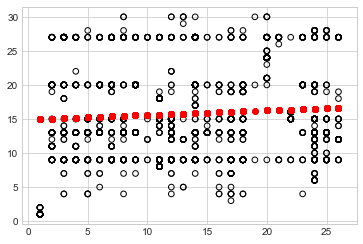

R-squared score: 0.0058


x= Product_1


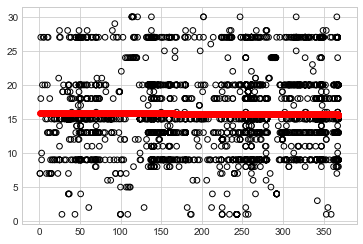

R-squared score: 0.0002


x= Product_2


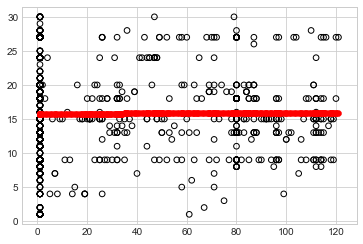

R-squared score: 0.0000




In [32]:
for category in X:
    print('x=', category)
    x = np.asarray(dfKBest[category]).reshape(-1, 1)
    regressor = LinearRegression(normalize=True).fit(x, y)
    y_pred    = regressor.predict(x)
    plot_scatter(x, y, y_pred)
    print("R-squared score: {:.4f}".format(r2_score(y, y_pred)))
    print()
    print()
